In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
from matplotlib.patches import Rectangle
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import Ridge

# Modeling the number of cases of COVID-19

## <font color='red'> Somehow I've gotten to this point without knowing how to actually create a model which forecasts the future. </font>


# Table of contents<a id='toc'></a>

## [COVID-19 Case number modeling ](#model)


## [COVID-19 Case number modeling with new features.](#modelplus)
***This section is a repeat of calculations with different data; the steps are described in the first modeling section.***

In [2]:
# Copied from last capstone project. 
def classifier_analysis(clf, X_test, y_test):
    
    '''
        Predict using trained scikit-learn estimator and compute and plot various metrics:
        Prints 
        
        Parameters:
        
        X_test : ndarray or DataFrame (n_samples, n_features)
                 Feature data to test. n_features represents the number of features
                 present in the data used to train the estimator clf
                 
        y_test : ndarray (n_samples, )
                 Target data to test. 
                
        
        clf : scikit-learn estimator which has been fit to data with same number of 
              columns as X_test
        
        
        Returns:
        
        y_test : ndarray (n_samples, )
            
            Same as input for convenience
        
        y_predict : ndarray (n_samples, ) 
            
            Predictions 
        
    '''
    
    y_predict = clf.predict(X_test)
    
    # Print the mean squared error and explained variance
    mse_ = mean_squared_error(y_test, y_predict)
    evs_ = explained_variance_score(y_test, y_predict)
    print('Mean squared error {}'.format(mse_))
    print('Explained variance score {}'.format(evs_))

    # Plot true vs. predicted as scatter plot. 
    ym = np.max(y_test)
    fig = plt.figure()
    plt.scatter(y_test, y_predict, s=1)
    plt.plot([0, ym],[0, ym],color='r')
    plt.ylabel('Predicted Value')
    plt.xlabel('True Value')
    plt.grid()
    plt.xlim([0, 1.1*ym])
    plt.ylim([0, 1.1*ym])
    _ = plt.show()
    
    return y_test, y_predict, evs_

# COVID-19 Case number modeling with no new features.
<a id='model'></a>
[Return to table of contents](#toc)

The first segment of the modeling process takes the "original" data, reformatted as per the
data cleaning notebook and then performs the necessary operations to encode the categorical variables.
The target variable is assigned to be the number of cases and the pipeline for the modeling process is as
follows (current iteration):
    
    1. Encode data, split into feature and target data.
    2. Create cross validation folds; split into train-test and holdout data sets. 
    2. Normalize the feature data via sklearn's StandardScaler. 
    3. Perform PCA on the normalized feature data
    4. Apply Ridge regression on the normalized, PCA transformed data. 

In [3]:
data = pd.read_csv('data.csv', index_col=0)
model_data = data.copy()

Create cross validation folds which respect the time-series dates.

In [4]:
n =  len(data.date.unique()) // 6
folds = [data.date.unique()[i:i+n+1] for i in range(0, 6 * n, n + 1)]
folds_indices = [data[data.date.isin(fold)].index for fold in folds]
folds_series = pd.Series(folds_indices).to_frame(name='folds')

full_index = folds_series.values.flatten()[:-1]
traintest_indices = full_index[0]
for other_indices in full_index[1:]:
    traintest_indices = traintest_indices.union(other_indices)

holdout_indices = folds_series.values.flatten()[-1]
model_data.loc[:, 'date'] = pd.to_datetime(data.loc[:, 'date'])
for i, epochs in enumerate(folds_series.values.flatten()):
    start, end = data.loc[epochs, 'date'].min(), data.loc[epochs, 'date'].max()
    print('Epoch {} spans the dates {} to {}'.format(i,start,end))

Epoch 0 spans the dates 2019-12-31 to 2020-01-21
Epoch 1 spans the dates 2020-01-22 to 2020-02-12
Epoch 2 spans the dates 2020-02-13 to 2020-03-05
Epoch 3 spans the dates 2020-03-06 to 2020-03-27
Epoch 4 spans the dates 2020-03-28 to 2020-04-18
Epoch 5 spans the dates 2020-04-19 to 2020-05-04


Cast bool features as int, one-hot encode the categorical (object) features.

In [5]:
bool_cols = data.select_dtypes(include='bool').columns
obj_cols = data.select_dtypes(include='object').columns

model_data.loc[:, bool_cols] = data.loc[:, bool_cols].astype('int')
obj_data_dummies = pd.get_dummies(data.loc[:, obj_cols], drop_first=True)
model_data = pd.concat((model_data.drop(columns=obj_cols), obj_data_dummies),axis=1)

Assign target variable and remove the corresponding variables from the regressors

In [6]:
y = model_data.cases_average
cases_features = model_data.columns[model_data.columns.str.contains('case')]
X = model_data.drop(columns=cases_features)

Split between traintest (Cross validation, currently used simply as a 1-fold training set)
and holdout (final testing).

In [7]:
X_traintest, y_traintest = X.loc[traintest_indices, :], y.loc[traintest_indices].values.ravel()
X_holdout, y_holdout = X.loc[holdout_indices, :], y.loc[holdout_indices].values.ravel()

Fit the StandardScaler() transformer instance with the training data; normalize both the
train and holdout feature data with this instance.

In [8]:
transformer = StandardScaler()
_ = transformer.fit(X_traintest)
X_traintest_whitened = transformer.transform(X_traintest)
X_holdout_whitened = transformer.transform(X_holdout)

Likewise, fit the PCA() transformer instance with the training data then apply it
to both the training and holdout sets.

In [9]:
pca = PCA(n_components=10)
_ = pca.fit(X_traintest_whitened)
X_tt_pca = pca.transform(X_traintest_whitened)
X_h_pca = pca.transform(X_holdout_whitened)

Finally, fit Ridge regression model to the training data, and test it with the holdout set.

Mean squared error 978768526.4108678
Explained variance score 0.8955380628529264


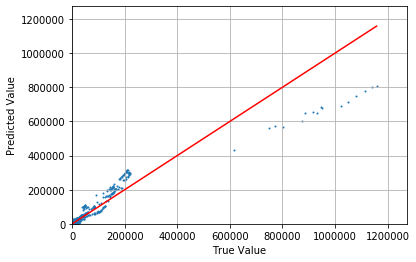

In [10]:
r = Ridge() 
_ = r.fit(X_tt_pca, y_traintest)
yr0, yr_predict0, evs0 = classifier_analysis(r, X_h_pca, y_holdout)

These results vastly exceeded my expectations (with respect to the explained variance score). 
**I am making a large mistake of including the variables from the future like deaths, active, recovered, etc. This model is not predicting the future.**

The predicted vs. the actual
value has two key patterns which stand out; namely, the underestimation of very large values and the overestimation of intermediate values (from one-hundred and fifth to two-hundred thousand). I think this is due to the nature of the case number time series. Looking to a one dimensional sigmoid curve as a crude example. This function is motivated by simple epidemiological models as a crude approximation for expected behavior. My model seems to imply that the larger values indicate that the spread of COVID is past the inflection point present in the sigmoid function.

In [11]:
country_groupby_indices = [data[data.location==country].index 
                           for country in data.location.unique()]
global_average_time_series = data.loc[country_groupby_indices[0], 'cases_average'].values
for c in country_groupby_indices[1:]:
    global_average_time_series += data.loc[c, 'cases_average'].values
global_average_time_series = global_average_time_series / len(country_groupby_indices)

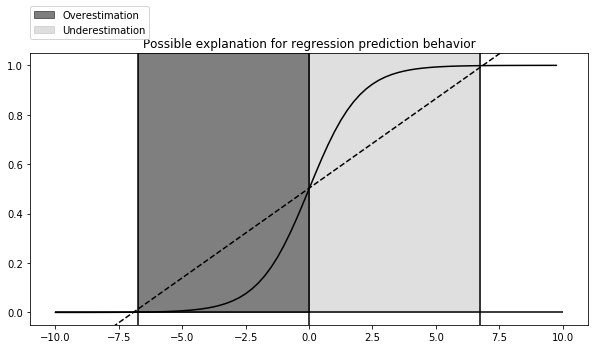

In [22]:
x = np.arange(-10, 10, 0.25)
sigmoid = 1.0 / (1.0 + np.exp(-x))

A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, sigmoid, rcond=None)[0]

over = np.where(((m * x + c - sigmoid) > 0)  & (x<=0))
under = np.where(((m * x + c - sigmoid) < 0) & (x>=0))
xover_width = x[over].max() - x[over].min() 
xunder_width = x[under].max() - x[under].min()

sigmoidmin, sigmoidmax = [-0.05, 1.05]

# fig, (ax,ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig, ax = plt.subplots(figsize=(10, 5))

_ = ax.plot(x, sigmoid, color='k')
_ = ax.plot(x, m * x + c, '--',color='k')
_ = ax.set_ylim([-0.05, 1.05])
_ = ax.vlines(x[over].min(), ymin=sigmoidmin, ymax=sigmoidmax)
_ = ax.vlines(0, ymin=sigmoidmin, ymax=sigmoidmax)
_ = ax.vlines(x[under].max(), ymin=sigmoidmin, ymax=sigmoidmax)
_ = ax.hlines(0, xmin=-10, xmax=10)
_ = ax.add_patch(Rectangle((x[over].min(), 0), xover_width, sigmoidmax, 
                           angle=0.0, alpha=0.5, color='k', label='Overestimation'))
_ = ax.add_patch(Rectangle((0, 0), x[under].max(), sigmoidmax, 
                           angle=0.0, alpha=0.25, color='gray', label='Underestimation'))

_ = ax.set_title('Possible explanation for regression prediction behavior')
_ = ax.legend(loc=(0,1.05))

Therefore, the Ridge regression predictions sort of make sense as the asymptotic behavior of the sigmoid curve
has not yet begun.

# COVID-19 Case number modeling with new features.
<a id='modelplus'></a>
[Return to table of contents](#toc)

Repeat the modeling steps above, applied to the dataset which calculated many different moving averages. 

In [13]:
data_new_features = pd.read_csv('modeling_data.csv', index_col=0)
model_data = data_new_features.copy()

model_data.loc[:, 'days_since_first'] = data_new_features.days_since_first_case.astype('int')

bool_cols = data_new_features.select_dtypes(include='bool').columns
obj_cols = data_new_features.select_dtypes(include='object').columns

model_data.loc[:, bool_cols] = data_new_features.loc[:, bool_cols].astype('int')
obj_data_dummies = pd.get_dummies(data_new_features.loc[:, obj_cols], drop_first=True)
model_data = pd.concat((model_data.drop(columns=obj_cols), obj_data_dummies),axis=1)

In [14]:
y = model_data.cases_average
cases_features = model_data.columns[model_data.columns.str.contains('case')]
X = model_data.drop(columns=cases_features)

Mean squared error 571419910.5096306
Explained variance score 0.9389519285325105


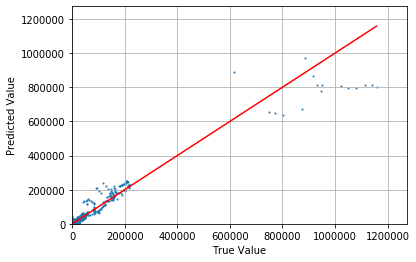

In [15]:
X_traintest, y_traintest = X.loc[traintest_indices, :], y.loc[traintest_indices].values.ravel()
X_holdout, y_holdout = X.loc[holdout_indices, :], y.loc[holdout_indices].values.ravel()
transformer = StandardScaler()
_ = transformer.fit(X_traintest)
X_traintest_whitened = transformer.transform(X_traintest)
X_holdout_whitened = transformer.transform(X_holdout)
pca = PCA(n_components=10)
_ = pca.fit(X_traintest_whitened)
X_tt_pca = pca.transform(X_traintest_whitened)
X_h_pca = pca.transform(X_holdout_whitened)
r = Ridge() 
_ = r.fit(X_tt_pca, y_traintest)
yrnf, yr_predictnf, evsnf  = classifier_analysis(r, X_h_pca, y_holdout)

Next, I look at the effect of the number of PCA components

In [16]:
ev_scores_pca = []
for n in range(1, 25):
    pca = PCA(n_components=n)
    _ = pca.fit(X_traintest_whitened)
    X_tt_pca = pca.transform(X_traintest_whitened)
    X_h_pca = pca.transform(X_holdout_whitened)
    r = Ridge() 
    _ = r.fit(X_tt_pca, y_traintest)
    y_predict = r.predict(X_h_pca)
    evsnf = explained_variance_score(y_holdout, y_predict)
    ev_scores_pca.append(evsnf)

Looking at the plot of explained variance versus number of PCA components I believe it is fairly obvious that
there is something wrong. I believe it's because I'm using different facets of the case number (deaths, active cases, number recovered) in the prediction.

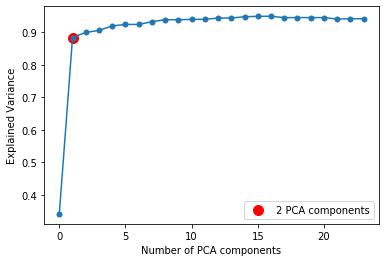

In [17]:
plt.plot(ev_scores_pca, marker='.', markersize=10)
plt.scatter(1, ev_scores_pca[1], color='r', s=100, label='2 PCA components')
plt.xlabel('Number of PCA components')
plt.ylabel('Explained Variance')
plt.legend()
plt.show()

Plot of explained variance score as a function of the features included; to see which features have the most effect.

In [18]:
ev_scores = []
for n in range(1, X_traintest_whitened.shape[1]):
    r = Ridge() 
    _ = r.fit(X_traintest_whitened[:, :n], y_traintest)
    y_predict = r.predict(X_holdout_whitened[:, :n])
    evsnf = explained_variance_score(y_holdout, y_predict)
    ev_scores.append(evsnf)

In [20]:
missing_flag_epoch = np.where(X.columns.str.contains('missing'))[0]
rolling_epoch = np.where(X.columns.str.contains('rolling'))[0]
location_dummies = np.where(X.columns.str.contains('location'))[0]
date_dummies = np.where(X.columns.str.contains('date'))[0]

There are a few features not included in the different "epochs"

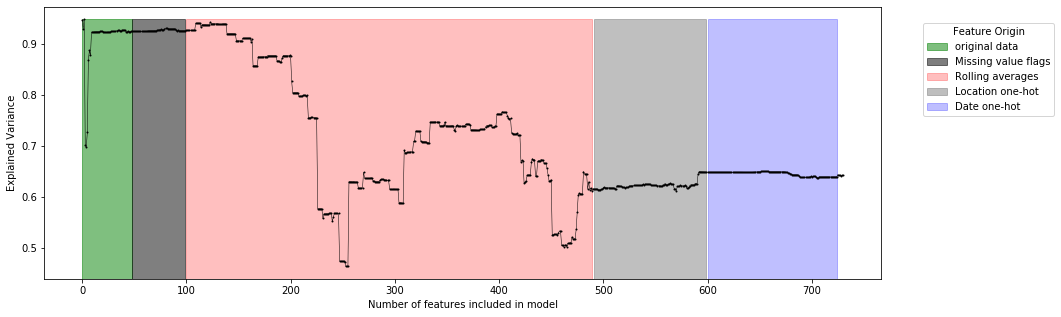

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
_ = ax.plot(ev_scores, marker='.', markersize=2, linewidth=0.5, color='k')

_ = ax.add_patch(Rectangle((0, 0), missing_flag_epoch.min(),  max(ev_scores), 
                           angle=0.0, alpha=0.5, color='g', label='original data'))

_ = ax.add_patch(Rectangle((missing_flag_epoch.min(), 0), 
                           missing_flag_epoch.max()-missing_flag_epoch.min(),  max(ev_scores), 
                           angle=0.0, alpha=0.5, color='k', label='Missing value flags'))

_ = ax.add_patch(Rectangle((rolling_epoch.min(), 0), 
                           rolling_epoch.max()-rolling_epoch.min(), max(ev_scores), 
                           angle=0.0, alpha=0.25, color='red', label='Rolling averages'))

_ = ax.add_patch(Rectangle((location_dummies.min(), 0),
                           location_dummies.max()-location_dummies.min(),  max(ev_scores), 
                           angle=0.0, alpha=0.5, color='gray', label='Location one-hot'))

_ = ax.add_patch(Rectangle((date_dummies.min(), 0), 
                           date_dummies.max()-date_dummies.min(), max(ev_scores), 
                           angle=0.0, alpha=0.25, color='blue', label='Date one-hot'))

_ = ax.set_ylabel('Explained Variance')
_ = ax.set_xlabel('Number of features included in model')
_ = plt.legend(loc=(1.05,0.6), title='Feature Origin')

This is not doing what I want. This is saying given I know the number of deaths/active cases/number recovered I can infer how many confirmed cases there were. This is not the same as predicting future numbers of cases. i.e. this is not plugging in a date (or days since first infection) and getting a number out.... 